# Steel Defect Identification Project - Exploratory Data Analysis

Like with any data science task, before we can move on to prepping and modeling our data we need a thorough understanding of the data we are dealing with. This notebook records the data understanding component of the CRISP-DM process for this project. 

## 1. Importing the Necessary Libraries

In [1]:
# Importing the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2

## 2. Image Counts
The first step in this process is to determine the size of our training set, our test set, and our dataset as a whole. 

In [2]:
# Getting the length of our train_images directory
train_filenames = list(os.walk('Original Dataset Package/Steel Images/train_images'))[0][2]

# Printing the result
print(f'There are {len(train_filenames)} images in our training set.')

There are 12568 images in our training set.


In [3]:
# Getting the length of our train_images directory
test_filenames = list(os.walk('Original Dataset Package/Steel Images/test_images'))[0][2]

# Printing the result
print(f'There are {len(test_filenames)} images in our test set.')

There are 5506 images in our test set.


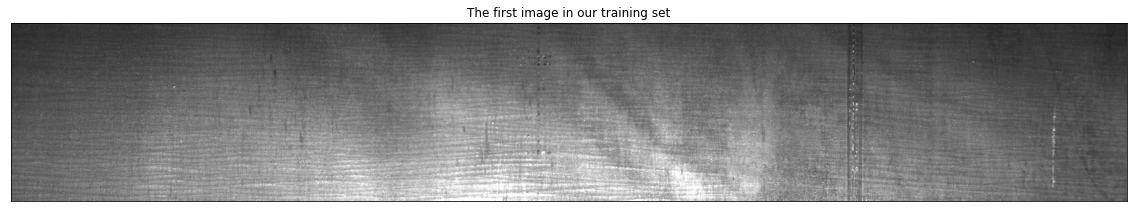

In [4]:
# Loading the first image in our training set using OpenCV
image_1 = cv2.imread('Original Dataset Package/Steel Images/train_images/58ee62fd7.jpg')

# Displaying the image
fig, ax = plt.subplots(figsize=(20,10))
plt.imshow(image_1)
plt.xticks([])
plt.yticks([])
plt.title('The first image in our training set');

In [5]:
# Checking the resolution and number of channels for our first image
image_1.shape

(256, 1600, 3)

With 18,074 images totalling to 1.72 GB, we should have plenty of images to train the neural networks with. It is also worth noting at this point that the train and test sets referred to in this notebook are the sets straight from the kaggle competition. There is no pbulicly available class label information (ground truths) for the 5506 images in the test set, as they are meant to be used as validation for the kaggle competition, and thus will not be used to train models. So in future notebooks, the 12568 image training set referred to in this notebook will be split into train, validation, and test sets.

Although it comes with information on 3 color channels, our first image is entirely grayscale, with a resolution of 256 x 1600.

## 3. Checking Uniformity of Image Formats
Our first image has a resolution of 256 pixels high by 1600 pixels wide, and it is important to know if all of our images come in the same format as that will determine what preprocessing steps we need to take. 

In [6]:
# Defining our resolution_check function
def resolution_check(array):
    
    '''This function takes either of our two arrays of filenames and returns how many 
    images in each directory have a resolution of 1600x256 with 3 color channels, and
    how many images do not.'''
    
    result = {'256 x 1600 x 3':0, 'other':0}
    
    if len(array) > 5506:
        dir_name = 'train_images/'
    else:
        dir_name = 'test_images/'
    
    for filename in array:
        filepath = 'Original Dataset Package/Steel Images/' + dir_name + filename
        image = cv2.imread(filepath)
        if image.shape == (256, 1600, 3):
            result['256 x 1600 x 3'] = result['256 x 1600 x 3'] + 1
        else:
            result['other'] = result['other'] + 1
            
    
    return result

In [7]:
#### Un comment out this cell at end $$$$
# Running our format checking function on the training images
print(f'Training image formats - {resolution_check(train_filenames)}')

# Running it on our test images
print(f'Test image formats - {resolution_check(test_filenames)}')

Training image formats - {'256 x 1600 x 3': 12568, 'other': 0}
Test image formats - {'256 x 1600 x 3': 5506, 'other': 0}


This confirms that every single image in both our train and test sets have a resolution of 256 by 1600, and 3 color channels. This is fortunate as it means all the images can be processed the same way. 

## 4. Class Distributions

The next critical step in the EDA process is to determine:
* How many classes of defect are there?
* How many classes of defect are present in each image?
* What is the distribution of defect classes among those that do contain defects?

### 4.1 Defects vs No Defects

In [8]:
# Importing the train.csv as a pandas dataframe
train_df = pd.read_csv('Original Dataset Package/train.csv')

# Displaying the shape
print(f'train_df shape: {train_df.shape}')

# Taking a look at the head of our dataframe
train_df.head()

train_df shape: (7095, 3)


ImageId  ClassId                                      EncodedPixels
0  0002cc93b.jpg        1  29102 12 29346 24 29602 24 29858 24 30114 24 3...
1  0007a71bf.jpg        3  18661 28 18863 82 19091 110 19347 110 19603 11...
2  000a4bcdd.jpg        1  37607 3 37858 8 38108 14 38359 20 38610 25 388...
3  000f6bf48.jpg        4  131973 1 132228 4 132483 6 132738 8 132993 11 ...
4  0014fce06.jpg        3  229501 11 229741 33 229981 55 230221 77 230468...

In [9]:
# Printing the number of unique file names in train_df, telling us the number of images with defects
print(f'There are {len(set(train_df["ImageId"]))} images in our training set with defects.')

# Subtracting 6666 from the number of total train images to find the count of images without defects
print(f'There are {len(train_filenames) - 6666} images in our training set without defects.')

There are 6666 images in our training set with defects.
There are 5902 images in our training set without defects.


In [10]:
# Comparing the number of images with defects, to the number of images without 
print(f'The 6666 images with defects makeup {round((6666 / len(train_filenames)) * 100, 2)}% of the total training images')
print(f'The 5902 images without defects makeup {round((5902 / len(train_filenames)) * 100, 2)}% of the total training images')

The 6666 images with defects makeup 53.04% of the total training images
The 5902 images without defects makeup 46.96% of the total training images


In [11]:
# Making a dictionary tying each filename to number of defect types for later use
defects_per_image_dict = dict(train_df['ImageId'].value_counts())

# This list holds the number of defect types for each unique filename in our dataframe
defects_per_image = list(train_df.ImageId.value_counts())

# The class labels of the defect types 
number_of_defect_types = ['0', '1', '2', '3']

# This list tracks number of defect types, '0' is preset to 5902 because there are 5902
# images in our training set with no defects present 
defect_type_counts = [5902, 0, 0, 0]

# Iterating through the defect type count list, tracking how many times each number appears
for i in defects_per_image:
    defect_type_counts[i] += 1
    
# Printing the results (so we can see how many have 3 labels)
print(*list(zip(number_of_defect_types, defect_type_counts)))
    
# Plotting the results
fig, ax  = plt.subplots(figsize=(8,5))
plt.bar(number_of_defect_types, defect_type_counts, width=.5, color='#4386a3')
plt.title('Number of Defect Types Per Image - Training Set')
plt.xlabel('Number of Defect Types')
plt.ylabel('Number of Images');

('0', 5902) ('1', 6239) ('2', 425) ('3', 2)


This chart tells us that in our training set, there are:
* 5902 images with no defects 
* 6239 images with one class of defect
* 425 images with two classes of defects
* 2 images with three classes of defects
* 0 images with four classes of defects

This means that 96.6% of our images exhibit either no defects, or only 1 class of defect.




### Note:

Since the provided csv uses numbers 1 through 4 as the labels for each class of defect, it is easy to misinterpret the two charts in this section. Therefore it is critical at this point to delineate the difference between:

1. The number of classes of defect present in each image (graphed above) 

    and 
    

2. The distribution of classes 1 through 4 (graphed below). 

### 4.2 Class Distribution Among Images Exhibiting Defects

ClassId
ClassLabel         
1               897
2               247
3              5150
4               801

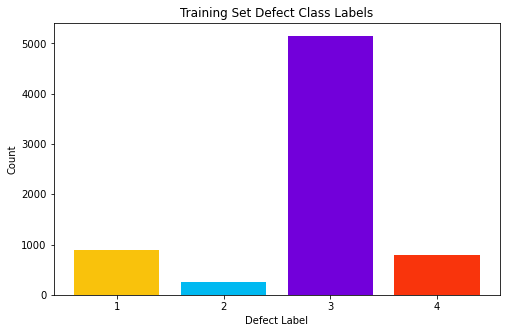

In [12]:
# Creating and sorting a dataframe that holds our class label distribution info
class_balance = pd.DataFrame(train_df.ClassId.value_counts())
class_balance['ClassLabel'] = [str(i) for i in class_balance.index]
class_balance.sort_values('ClassLabel', inplace=True)
class_balance.set_index(['ClassLabel'], inplace=True)

# Displaying our dataframe
display(class_balance)

# Color coding the different defect types, these colors will be consistent throughout the project
color_list = [ '#f9c20c', '#00b9f1', '#7200da', '#f9340c']

# Plotting the distribution
fig, ax = plt.subplots(figsize=(8,5))
plt.bar(class_balance.index, class_balance['ClassId'], color=color_list)
plt.title('Training Set Defect Class Labels')
plt.xlabel('Defect Label')
plt.ylabel('Count');

## 5. Visualizing Defect Masks by Defect Class

The following images come from kaggle user MaXXX (https://www.kaggle.com/finlay) and the original code that produced these images can be found at this link https://www.kaggle.com/finlay/clear-mask-visualization-and-simple-eda. 

Due to time constraints, I did not have a chance to go through the process of taking sample images from each class of defect and visualizing which pixels are responsible for that class of defect. I felt however that this step would be a significant value add for the EDA portion of this project, so I have included MaXXX's images below. 

### 5.1 No Defects 

It is clear from just 3 images that there is a wide variance in content from image to image, even in the images containing no defects. This speaks to the difficulty of this particular problem, and the possible challenges in the modeling stages. 



### 5.2 Class 1 Defects

Class 1 defects appear to be small, localized areas that could be overlooked if the training images are downscaled too aggressively. 

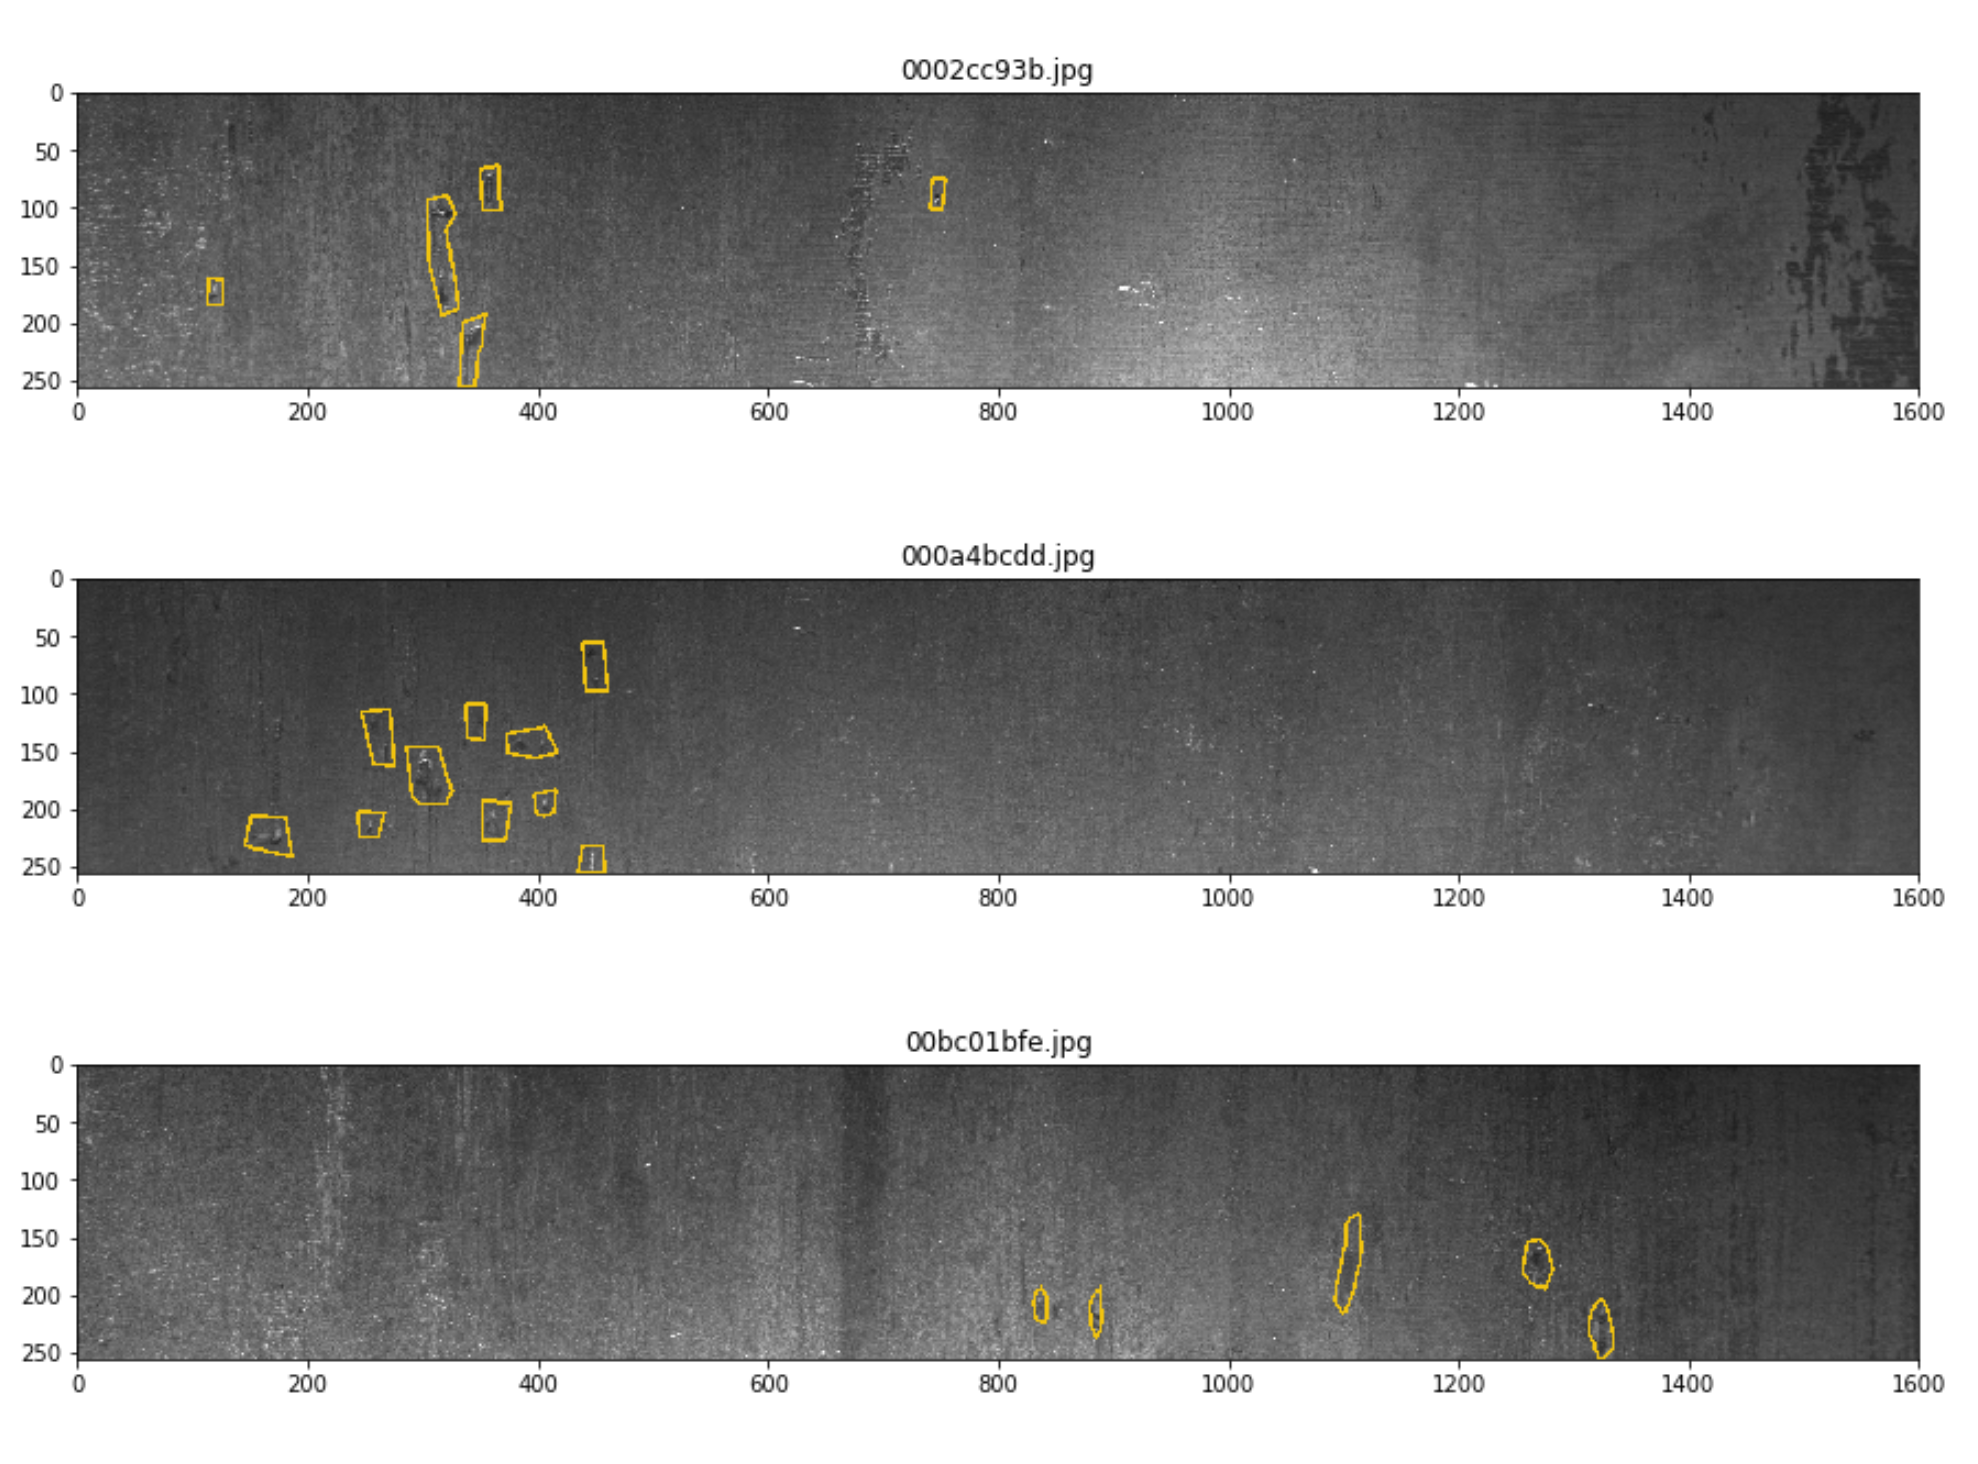

### 5.3 Class 2 Defects

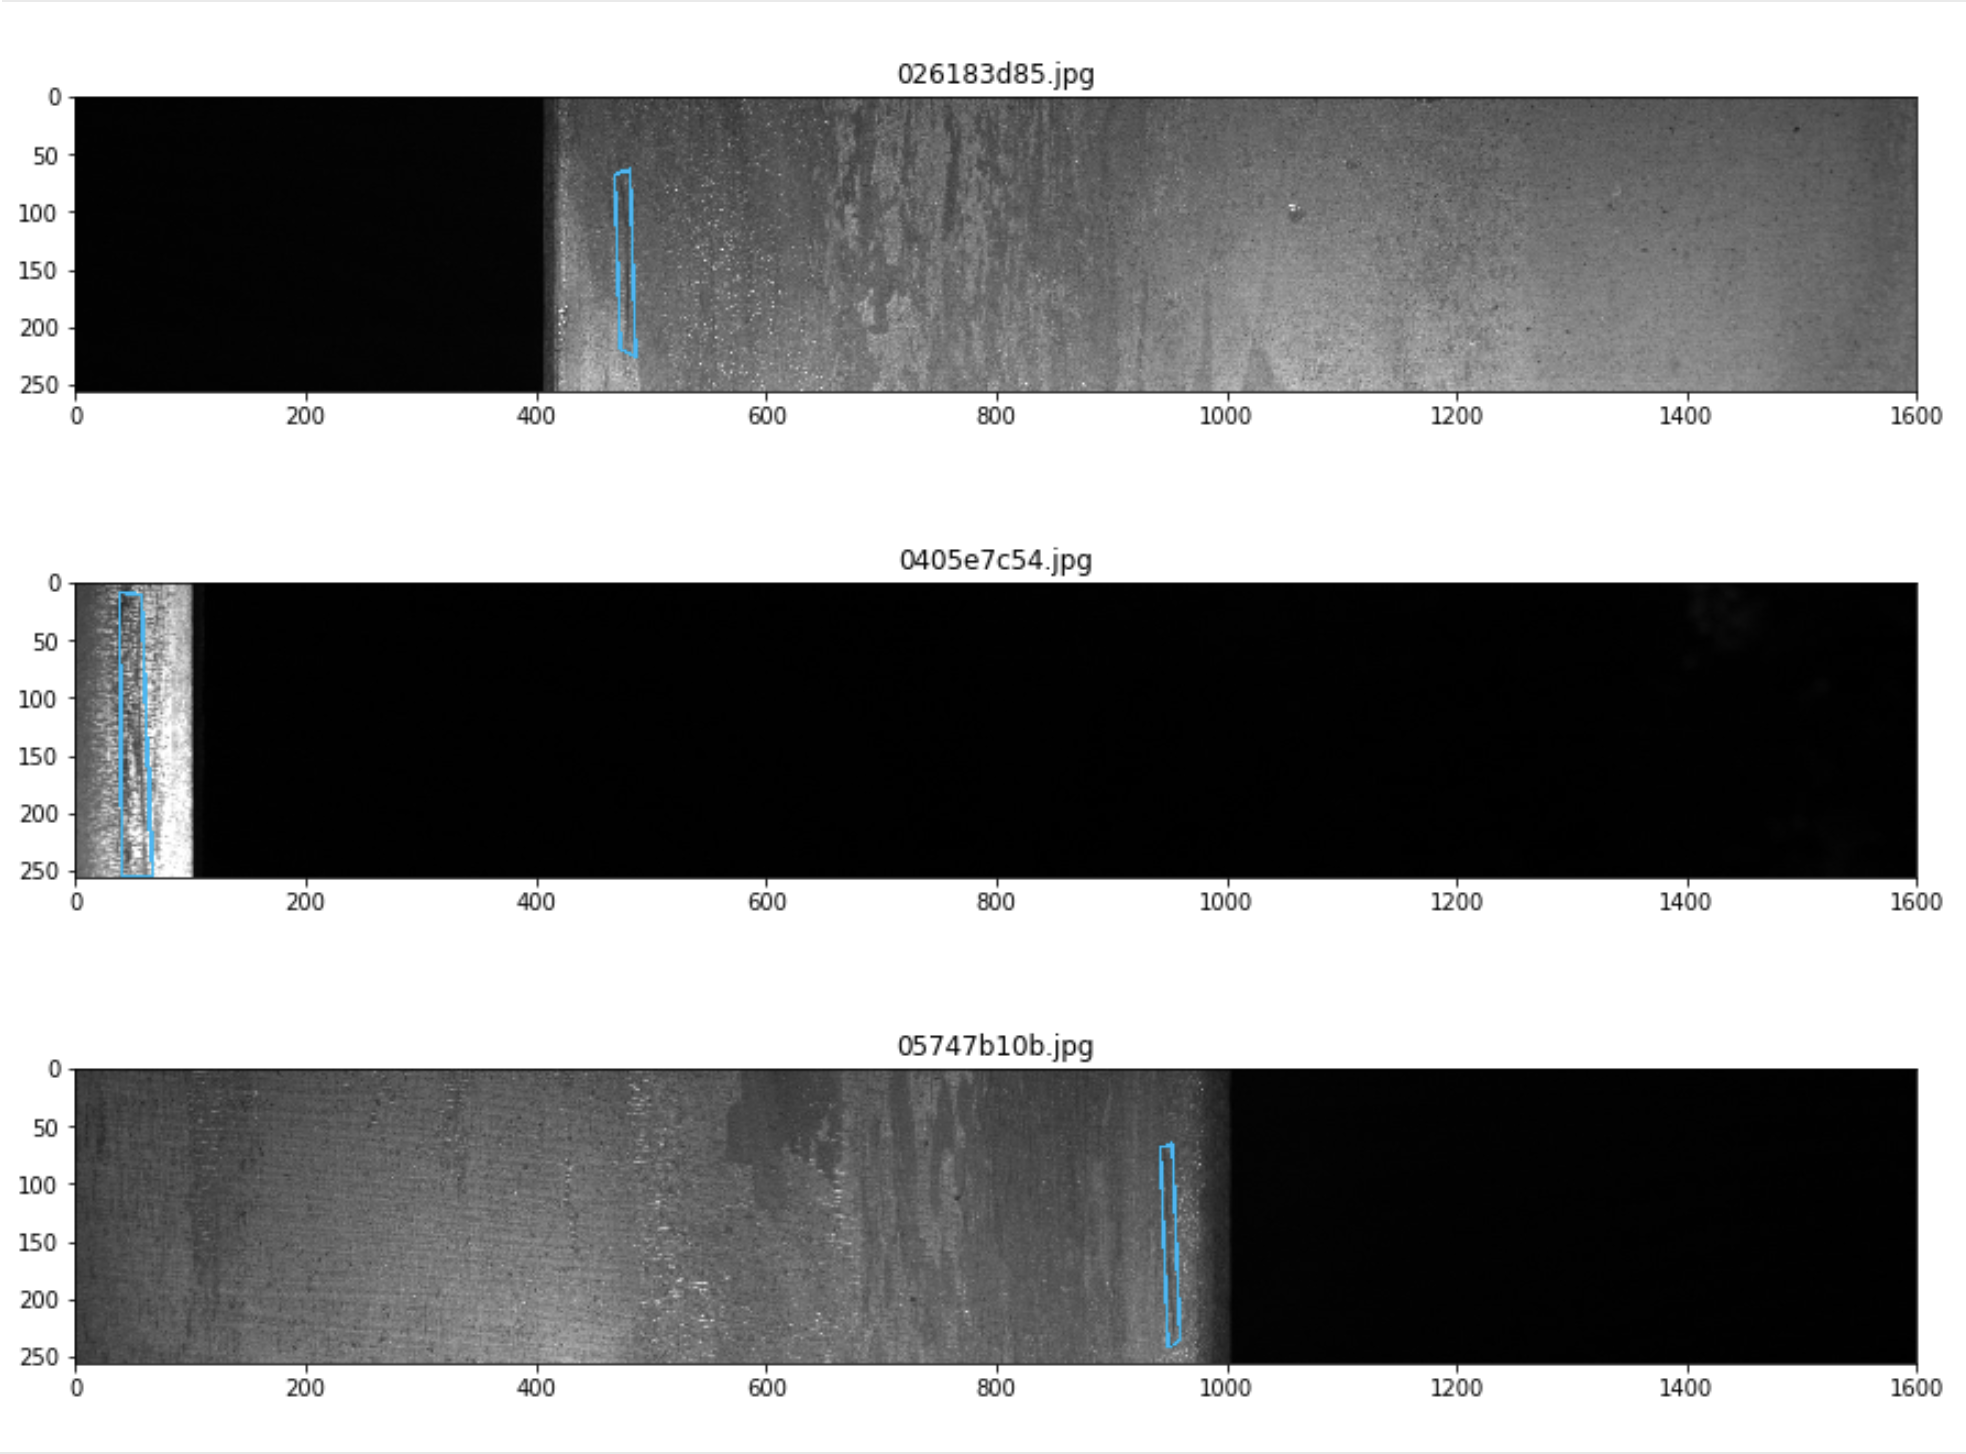

### 5.4 Class 3 Defects



### 5.5 Class 4 Defects


## 6. Final Thoughts
This EDA process has revealed the different possible approaches to implementing a business use case for models trained on this dataset.

### Binary Classification 
With a 53 - 47 split between images with defects and without defects respectively, one way to frame this problem is as a binary classification problem. Perhaps as steel flows through the production process, pieces with defects are identified and removed from the production line and dealt with accordingly. 

### Multiclass Classification
Since the defect types are not mutually exclusive, this task is technically a multilabel classification problem, not a multiclass one. However because 97% of our images contain either no defects or one class of defect, the task at hand will require significant training time, and there is a significant class imbalance among images with defects, my approach will be to treat this as a multiclass classification problem. 

Multiclass classification could be deployed in production similarly to binary classification, where defects of certain classes are redirected from the main production line into seperate production streams. 

### Instance Segmentation
A much more sophisticated application of computer vision in this business context would be instance segmentation within the images. This would require the use of a Mask R-CNN to not only identify defects, but localize and map which pixels made up each class and instance of defect. 

While the most complicated and computationally intensive, instance segmentation would give the steel manufacturers the most flexibility in deployment, partly because binary and multiclass sorting could be done in the same way as with the simpler model implementations. Instance segmentation would additionally give engineers the ability to calculate an overall condition score based on the type of defects, where they were located on the piece, and the total number of pixels corresponding to defects. If certain defects are more detrimental to the structural integrity of a piece, their contribution to this overall condition score could be weighted appropriately. Similarly, if the location of a defect in a specific area is more unnacceptable, the count of pixels representing defects in these areas could also be weighted accordingly in the overall condition score.